# ⤵️Import Libraries

In [19]:
import os
import re
import numpy as np
import pandas as pd
import datetime as dt

import seaborn as sns
import plotly.io as pio
import plotly.express as px
import plotly.graph_objs as go

import xlrd
import pickle as pkl

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from scipy.stats.mstats import winsorize
from scipy.stats.mstats import zscore
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge

In [2]:
#pd.set_option('mode.use_inf_as_null', True)

In [3]:
col_pal = ['#8236CB', 
           '#EB2632']

# 📂Load Data

In [4]:
os.chdir('..')
curr_dir = (os.getcwd()).replace('\\', '/')
file_path = curr_dir + '/Dataset/Healthcare_dataset.xlsx'

In [5]:
drug_df = pd.read_excel(file_path, sheet_name='Dataset')

In [11]:
drug_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3424 entries, 0 to 3423
Data columns (total 69 columns):
 #   Column                                                              Non-Null Count  Dtype 
---  ------                                                              --------------  ----- 
 0   Ptid                                                                3424 non-null   object
 1   Persistency_Flag                                                    3424 non-null   object
 2   Gender                                                              3424 non-null   object
 3   Race                                                                3424 non-null   object
 4   Ethnicity                                                           3424 non-null   object
 5   Region                                                              3424 non-null   object
 6   Age_Bucket                                                          3424 non-null   object
 7   Ntm_Speciality          

In [6]:
drug_df.head()

,Ptid,Persistency_Flag,Gender,Race,Ethnicity,Region,Age_Bucket,Ntm_Speciality,Ntm_Specialist_Flag,Ntm_Speciality_Bucket,...,Risk_Family_History_Of_Osteoporosis,Risk_Low_Calcium_Intake,Risk_Vitamin_D_Insufficiency,Risk_Poor_Health_Frailty,Risk_Excessive_Thinness,Risk_Hysterectomy_Oophorectomy,Risk_Estrogen_Deficiency,Risk_Immobilization,Risk_Recurring_Falls,Count_Of_Risks
0,P1,Persistent,Male,Caucasian,Not Hispanic,West,>75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,...,N,N,N,N,N,N,N,N,N,0
1,P2,Non-Persistent,Male,Asian,Not Hispanic,West,55-65,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,...,N,N,N,N,N,N,N,N,N,0
2,P3,Non-Persistent,Female,Other/Unknown,Hispanic,Midwest,65-75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,...,N,Y,N,N,N,N,N,N,N,2
3,P4,Non-Persistent,Female,Caucasian,Not Hispanic,Midwest,>75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,...,N,N,N,N,N,N,N,N,N,1
4,P5,Non-Persistent,Female,Caucasian,Not Hispanic,Midwest,>75,GENERAL PRACTITIONER,Others,OB/GYN/Others/PCP/Unknown,...,N,N,N,N,N,N,N,N,N,1


Convert feature names into LOWERCASE.

In [6]:
drug_df.columns = list(map(lambda x:x.lower(), list(drug_df.columns)))

# 🧹Cleaning Data

In [8]:
cols = ((drug_df != 'N') & (drug_df != 'Y')).any() 

In [9]:
cols

ptid                               True
persistency_flag                   True
gender                             True
race                               True
ethnicity                          True
                                  ...  
risk_hysterectomy_oophorectomy    False
risk_estrogen_deficiency          False
risk_immobilization               False
risk_recurring_falls              False
count_of_risks                     True
Length: 69, dtype: bool

In [10]:
features = cols[cols].index.tolist()
features

['ptid',
 'persistency_flag',
 'gender',
 'race',
 'ethnicity',
 'region',
 'age_bucket',
 'ntm_speciality',
 'ntm_specialist_flag',
 'ntm_speciality_bucket',
 'dexa_freq_during_rx',
 'risk_segment_prior_ntm',
 'tscore_bucket_prior_ntm',
 'risk_segment_during_rx',
 'tscore_bucket_during_rx',
 'change_t_score',
 'change_risk_segment',
 'adherent_flag',
 'count_of_risks']

In [11]:
cols_ign = ['ptid', 'gender', 'dexa_freq_during_rx', 'count_of_risks']

for cols in features:
    if cols not in cols_ign:
        print(drug_df[cols].value_counts())
        print('\n')

persistency_flag
Non-Persistent    2135
Persistent        1289
Name: count, dtype: int64


race
Caucasian           3148
Other/Unknown         97
African American      95
Asian                 84
Name: count, dtype: int64


ethnicity
Not Hispanic    3235
Hispanic          98
Unknown           91
Name: count, dtype: int64


region
Midwest          1383
South            1247
West              502
Northeast         232
Other/Unknown      60
Name: count, dtype: int64


age_bucket
>75      1439
65-75    1086
55-65     733
<55       166
Name: count, dtype: int64


ntm_speciality
GENERAL PRACTITIONER                                              1535
RHEUMATOLOGY                                                       604
ENDOCRINOLOGY                                                      458
Unknown                                                            310
ONCOLOGY                                                           225
OBSTETRICS AND GYNECOLOGY                                        

## Checking for null values 

In [12]:
drug_df.isna().sum()

ptid                              0
persistency_flag                  0
gender                            0
race                              0
ethnicity                         0
                                 ..
risk_hysterectomy_oophorectomy    0
risk_estrogen_deficiency          0
risk_immobilization               0
risk_recurring_falls              0
count_of_risks                    0
Length: 69, dtype: int64

There are no missing or null values in the dataset.

## Identifying and Handling Outliers 

Identify possible features containing outliers and treat them using different methods.

### Demographics 

> - Gender
> - Race
> - Ethinicity

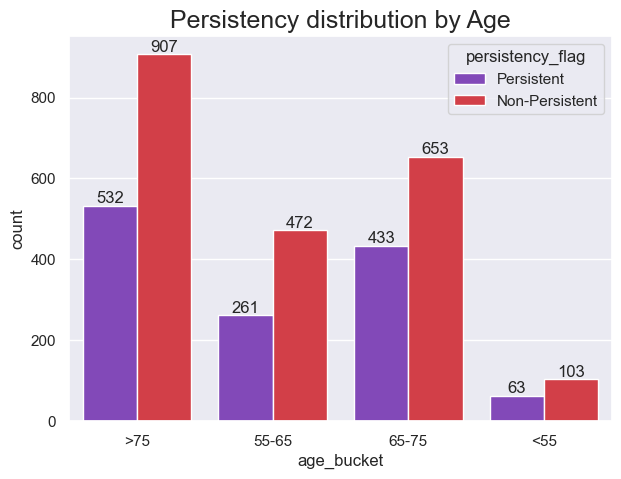

In [13]:
sns.set(rc = {'figure.figsize':(7,5)})
ax = sns.countplot(x='age_bucket', 
                   data=drug_df, 
                   hue='persistency_flag', 
                   palette=col_pal)
ax.set_title('Persistency distribution by Age', 
             fontsize=18)
for label in ax.containers:
    ax.bar_label(label)

Majority of the patients recorded in the dataset are above *55 years* of age.

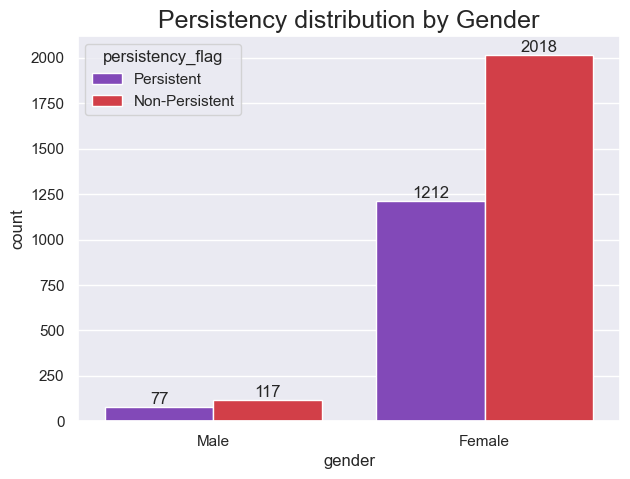

In [14]:
sns.set(rc = {'figure.figsize':(7,5)})
ax = sns.countplot(x='gender', 
                   data=drug_df, 
                   hue='persistency_flag', 
                   palette=col_pal)
ax.set_title('Persistency distribution by Gender', 
             fontsize=18)
for label in ax.containers:
    ax.bar_label(label)

The **Male** records in the dataset are very low as compared to **Females**. Hence, we can drop this column as it doesn't contribute to model training and would rather add bias in the model.

In [23]:
drug_df.drop('gender', axis=1, inplace=True)

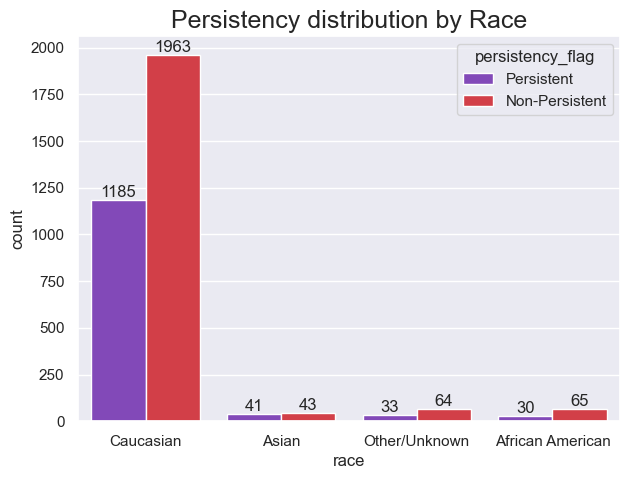

In [15]:
sns.set(rc = {'figure.figsize':(7,5)})
ax = sns.countplot(x='race', 
                   data=drug_df, 
                   hue='persistency_flag', 
                   palette=col_pal)
ax.set_title('Persistency distribution by Race', 
             fontsize=18)
for label in ax.containers:
    ax.bar_label(label)

Majority of the population recorded are *Caucasian*. Hence, we can drop the feature **Race** as a non-contributing factor for model training.

In [25]:
drug_df.drop('race', axis=1, inplace=True)

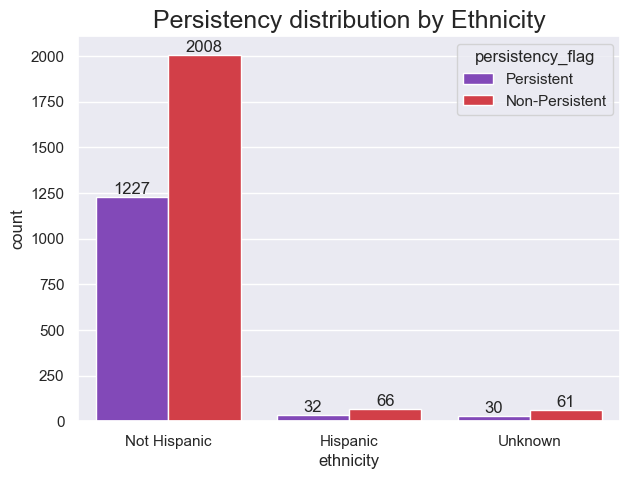

In [16]:
sns.set(rc = {'figure.figsize':(7,5)})
ax = sns.countplot(x='ethnicity', 
                   data=drug_df, 
                   hue='persistency_flag', 
                   palette=col_pal)
ax.set_title('Persistency distribution by Ethnicity', 
             fontsize=18)
for label in ax.containers:
    ax.bar_label(label)

Majority of the population recorded are **Non Hispanic**. Hence, we can drop the feature **Ethnicity** as a non-contributing factor for model training.

In [26]:
drug_df.drop('ethnicity', axis=1, inplace=True)

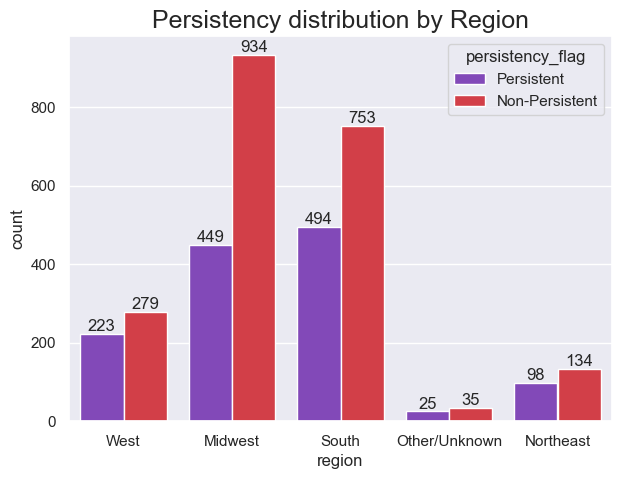

In [17]:
sns.set(rc = {'figure.figsize':(7,5)})
ax = sns.countplot(x='region', 
                   data=drug_df, 
                   hue='persistency_flag', 
                   palette=col_pal)
ax.set_title('Persistency distribution by Region', 
             fontsize=18)
for label in ax.containers:
    ax.bar_label(label)

### NTM Physician Attributes 

> - NTM Physician specialist
> - Physician Specialist flag
> - Physician Specialist bucket

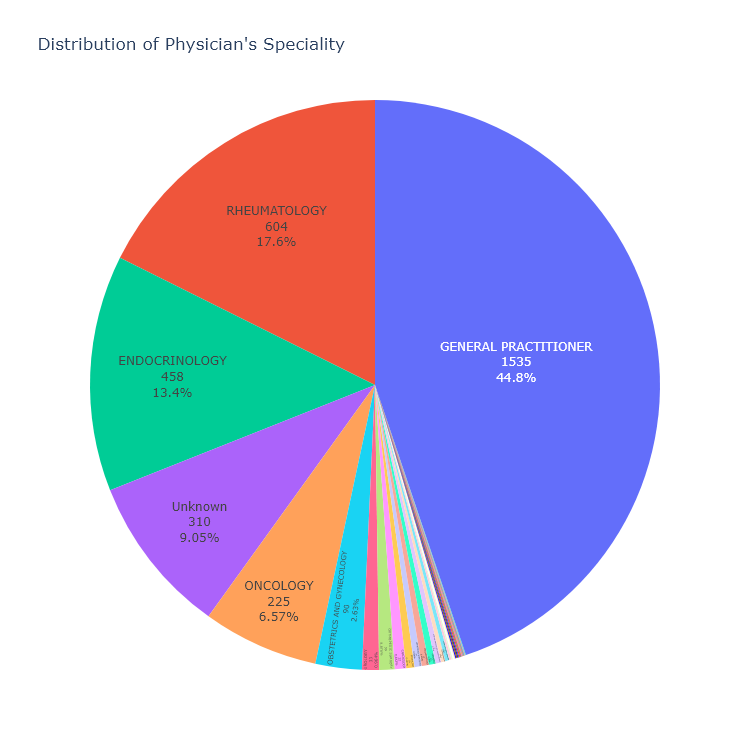

In [6]:
per_phy = drug_df.groupby('ntm_speciality').count()

fig = px.pie(per_phy, 
             values=per_phy.ptid, 
             names=per_phy.index, 
             title='Distribution of Physician\'s Speciality')
fig.update_traces(textposition='inside', 
                  textinfo='value+label+percent')
fig.update_layout(width=750, 
                  height=750)
fig.update(layout_showlegend=False)
fig.show("png")
#fig.show()

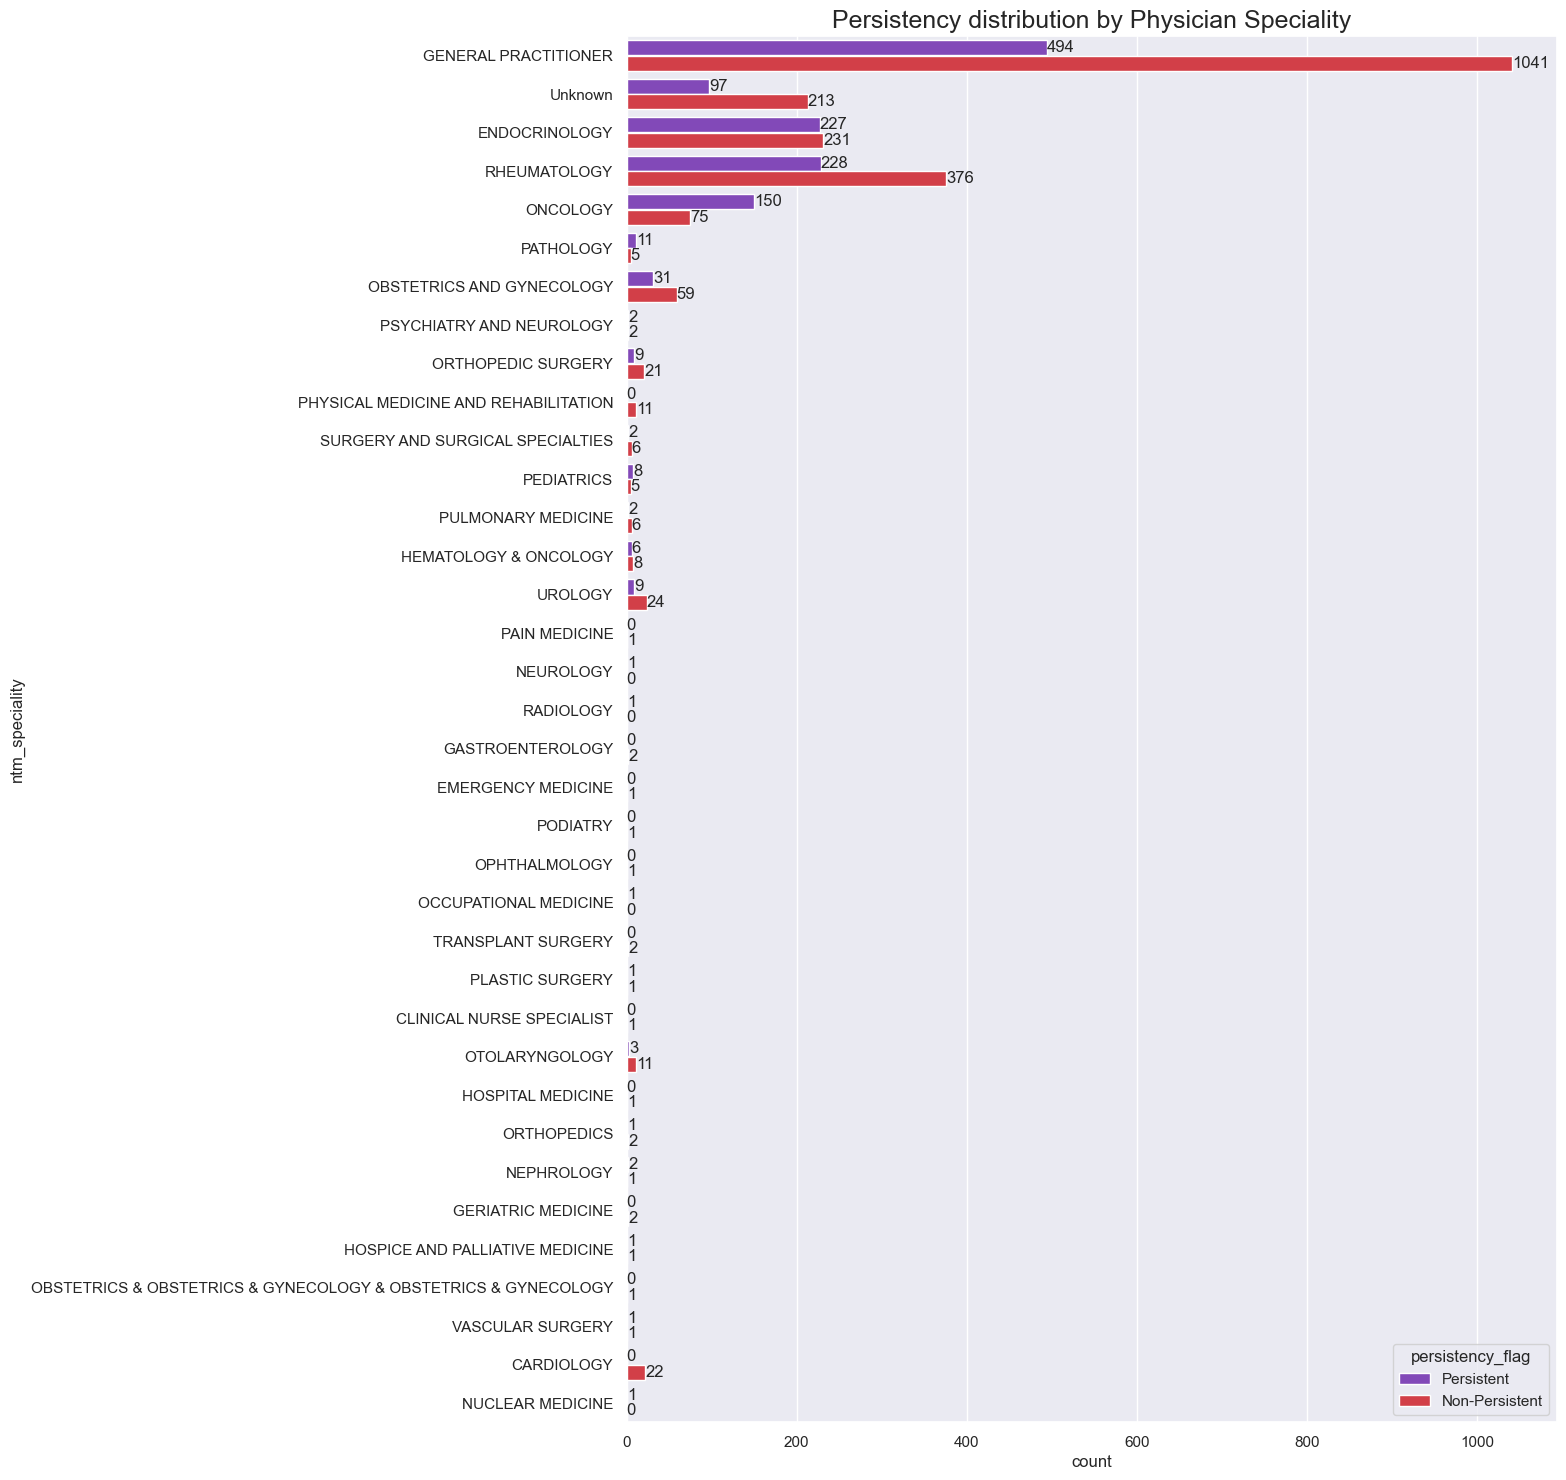

In [9]:
sns.set(rc = {'figure.figsize':(12,18)})
ay = sns.countplot(y='ntm_speciality', 
                   data=drug_df, 
                   hue='persistency_flag', 
                   palette=col_pal)
#plt.xticks(rotation=45)
ay.set_title('Persistency distribution by Physician Speciality', 
             fontsize=18)
for label in ay.containers:
    ay.bar_label(label)

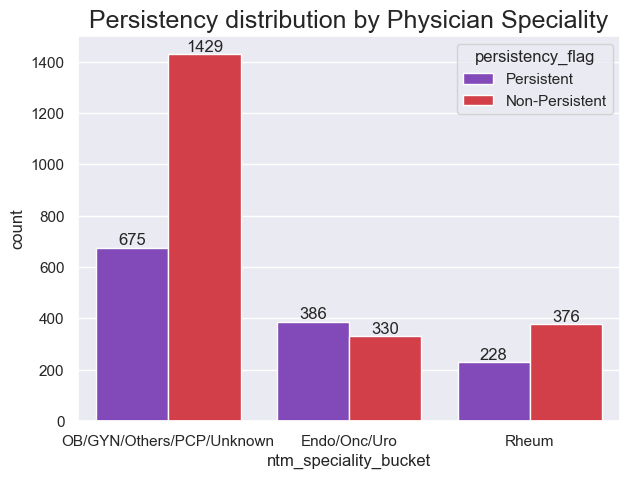

In [11]:
sns.set(rc = {'figure.figsize':(7,5)})
ax = sns.countplot(x='ntm_speciality_bucket', 
                   data=drug_df, 
                   hue='persistency_flag', 
                   palette=col_pal)
#plt.xticks(rotation=45)
ax.set_title('Persistency distribution by Physician Speciality', 
             fontsize=18)
for label in ax.containers:
    ax.bar_label(label)

When comparing the features *ntm_speciality* and *ntm_speciality_bucket*, we can observe that the former has significant number of outliers. A workaround is to use the latter feature which divides the specialities into 3 different categories and drop the former attribute.

In [27]:
drug_df.drop('ntm_speciality', axis=1, inplace=True)

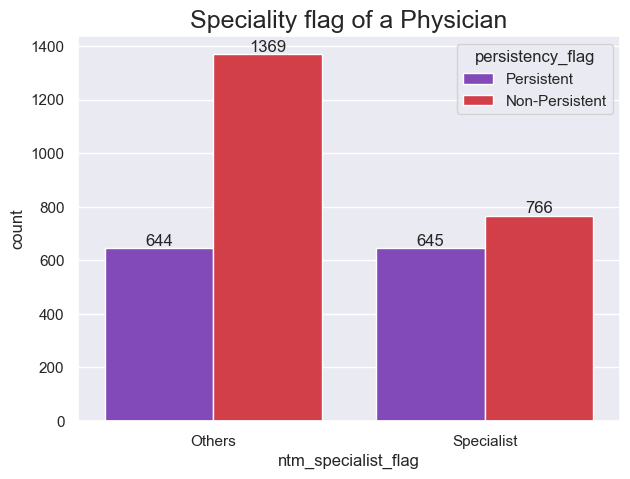

In [12]:
sns.set(rc = {'figure.figsize':(7,5)})
ax = sns.countplot(x='ntm_specialist_flag', 
                   data=drug_df, 
                   hue='persistency_flag', 
                   palette=col_pal)
#plt.xticks(rotation=45)
ax.set_title('Speciality flag of a Physician', 
             fontsize=18)
for label in ax.containers:
    ax.bar_label(label)

### Clinical Factors 

> - TScore
> - Risk Segment
> - DEXA
> - Fragility Fracture
> - Glucocorticoid 

### Dexa Scan frequency during NTM Rx 

- *Outliers Identification*

>- ***Boxplot visualisation***

Text(0.5, 1.0, 'DEXA scan frequency during NTM Rx')

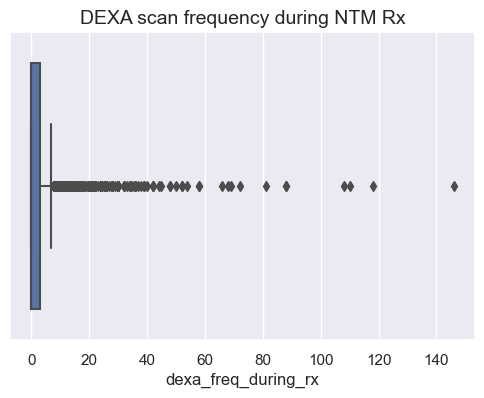

In [13]:
sns.set(rc = {'figure.figsize':(6,4)})
ax = sns.boxplot(x='dexa_freq_during_rx', 
                 data=drug_df)
ax.set_title('DEXA scan frequency during NTM Rx', 
             fontsize=14)

Text(0.5, 1.0, 'DEXA scan frequency during NTM Rx')

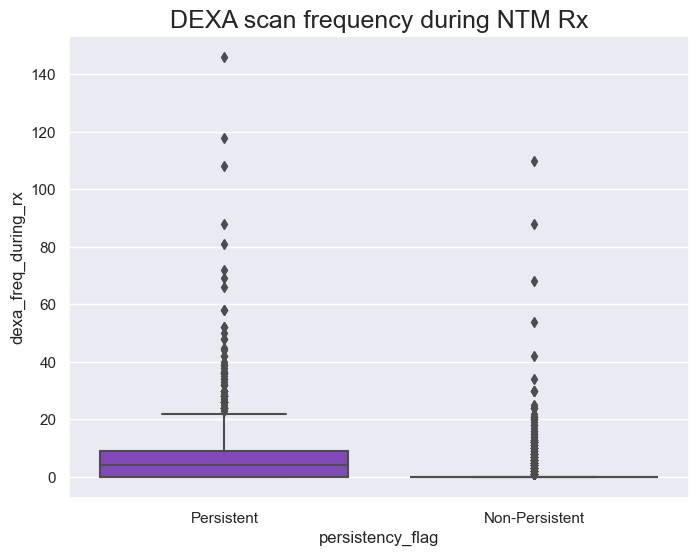

In [16]:
sns.set(rc = {'figure.figsize':(8,6)})
ax = sns.boxplot(y='dexa_freq_during_rx', 
                 x='persistency_flag',
                 data=drug_df,
                 palette=col_pal)
ax.set_title('DEXA scan frequency during NTM Rx', 
             fontsize=18)

>- ***Histogram visualisation***

Text(0.5, 1.0, 'Histogram for DEXA frequency during NTM Rx')

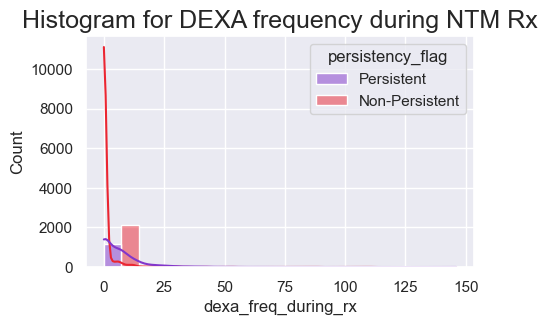

In [22]:
sns.set(rc = {'figure.figsize':(5, 3)})
ax = sns.histplot(x='dexa_freq_during_rx', 
                  hue='persistency_flag',
                  stat='count',
                  data=drug_df,
                  palette=col_pal,
                  multiple='dodge', 
                  bins=10,
                  kde=True)
#ax.set_xlim(0, 40)
#ax.set_ylim(0, 750)
ax.set_title('Histogram for DEXA frequency during NTM Rx', 
             fontsize=18)

In [25]:
drug_df.groupby('persistency_flag')['dexa_freq_during_rx'].describe()

,count,mean,std,min,25%,50%,75%,max
persistency_flag,,,,,,,,
Non-Persistent,2135.0,0.896956,4.695774,0.0,0.0,0.0,0.0,110.0
Persistent,1289.0,6.525989,10.937832,0.0,0.0,4.0,9.0,146.0


- ***Inter Quantile Range(IQR)***

In [7]:
Q1 = drug_df['dexa_freq_during_rx'].quantile(0.25)
Q3 = drug_df['dexa_freq_during_rx'].quantile(0.75)
IQR = Q3 - Q1
lwr_bound = Q1 - (1.5 * IQR)
upr_bound = Q3 + (1.5 * IQR)
drug_df[drug_df['dexa_freq_during_rx'] > upr_bound].groupby('persistency_flag')['dexa_freq_during_rx'].describe()

,count,mean,std,min,25%,50%,75%,max
persistency_flag,,,,,,,,
Non-Persistent,78.0,17.717949,16.795096,8.0,10.0,12.0,19.75,110.0
Persistent,382.0,17.277487,14.905000,8.0,10.0,12.0,19.75,146.0


The *dexa_freq_during_rx* feature has outliers which account to around 460 records. As the strength of total records in the dataset is less in number, removing these outliers is not an option.

>- ***Z-Score method***

In [37]:
thres = 1.96
outliers = []
z_score = np.abs(zscore(drug_df['dexa_freq_during_rx']))

for idx, val in enumerate(z_score):
    if val > thres:
        outliers.append(idx)

In [38]:
for idx in outliers:
    print('{}: {}'.format(idx, drug_df['dexa_freq_during_rx'][idx]))

32: 20
65: 20
101: 25
186: 21
198: 28
201: 22
241: 37
457: 21
462: 22
541: 81
651: 42
1265: 28
1273: 22
1360: 30
1370: 42
1396: 19
1398: 45
1550: 27
1554: 21
1566: 24
1599: 22
1691: 22
1732: 19
1734: 58
1803: 26
1834: 23
1838: 33
1854: 58
1901: 110
1909: 36
1910: 26
1920: 34
1949: 28
1965: 26
1982: 26
1988: 24
1993: 88
1996: 24
1997: 21
2002: 19
2005: 26
2006: 30
2010: 26
2013: 66
2015: 24
2016: 22
2024: 32
2028: 88
2030: 30
2033: 118
2042: 20
2043: 24
2044: 48
2058: 20
2060: 28
2065: 36
2083: 20
2086: 22
2132: 69
2134: 38
2139: 26
2142: 30
2151: 40
2163: 20
2168: 32
2169: 24
2171: 26
2175: 20
2176: 68
2178: 26
2187: 24
2189: 20
2196: 20
2197: 52
2205: 50
2214: 20
2215: 146
2227: 20
2233: 21
2237: 30
2240: 22
2264: 22
2271: 28
2275: 34
2278: 52
2298: 48
2308: 28
2310: 20
2314: 44
2329: 20
2350: 21
2359: 21
2379: 32
2390: 20
2393: 42
2413: 22
2422: 22
2503: 35
2529: 30
2557: 39
2558: 36
2570: 24
2575: 20
2603: 108
2608: 36
2681: 54
2686: 39
2696: 24
2713: 34
2751: 72
2757: 30
2789: 29
2

- *Handling outliers*

>- ***Winsorize*** method for handling outliers

In [8]:
print('Lower bound: {}'.format(lwr_bound))
print('Upper bound: {}'.format(upr_bound))

Lower bound: -4.5
Upper bound: 7.5


In [9]:
print('5\u1d57\u02b0 Percentile: {}'.format(drug_df['dexa_freq_during_rx'].quantile(0.05)))

5ᵗʰ Percentile: 0.0


In [10]:
print('87\u1d57\u02b0 Percentile: {}'.format(drug_df['dexa_freq_during_rx'].quantile(0.87)))
print('90\u1d57\u02b0 Percentile: {}'.format(drug_df['dexa_freq_during_rx'].quantile(0.90)))
print('92.5\u1d57\u02b0 Percentile: {}'.format(drug_df['dexa_freq_during_rx'].quantile(0.925)))
print('95\u1d57\u02b0 Percentile: {}'.format(drug_df['dexa_freq_during_rx'].quantile(0.95)))
print('97.5\u1d57\u02b0 Percentile: {}'.format(drug_df['dexa_freq_during_rx'].quantile(0.975)))
print('99\u1d57\u02b0 Percentile: {}'.format(drug_df['dexa_freq_during_rx'].quantile(0.99)))

87ᵗʰ Percentile: 8.0
90ᵗʰ Percentile: 10.0
92.5ᵗʰ Percentile: 12.0
95ᵗʰ Percentile: 14.0
97.5ᵗʰ Percentile: 22.0
99ᵗʰ Percentile: 34.76999999999998


Here, the $87^{th}$, $90^{th}$, $92.5^{th}$ and $95^{th}$ percentiles are close to the upper bound limit. Hence, we can user $95^{th}$ percentile as the capping limit in the **Winsorize** method. 

In [11]:
drug_df['dexa_freq_during_rx_win'] = winsorize(drug_df['dexa_freq_during_rx'], limits=(0.05, 0.05))

Text(0.5, 1.0, 'DEXA scan frequency during NTM Rx after Winsorization method')

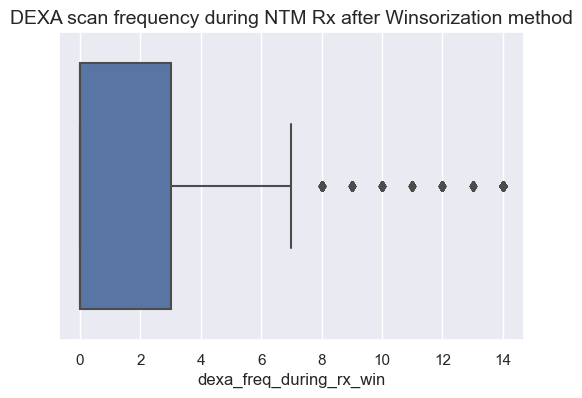

In [12]:
sns.set(rc = {'figure.figsize':(6,4)})
ax = sns.boxplot(x='dexa_freq_during_rx_win', 
                 data=drug_df)
ax.set_title('DEXA scan frequency during NTM Rx after Winsorization method', 
             fontsize=14)

As we can see the presence of outliers in the *dexa_freq_during_rx* feature has significantly decreased after applying **Winsorization** method.

In [15]:
print('Skewness of data before Winsorization: {}'.format(drug_df['dexa_freq_during_rx'].skew()))
print('Skewness of data after Winsorization: {}'.format(drug_df['dexa_freq_during_rx_win'].skew()))

Skewness of data before Winsorization: 6.8087302112992285
Skewness of data after Winsorization: 1.7354193032563636


>- ***Log Transformation*** method for handling outliers

In [16]:
drug_df['dexa_freq_during_rx_log'] = drug_df['dexa_freq_during_rx'].map(lambda x: np.log(x) if x>0 else 0)

In [19]:
max(drug_df['dexa_freq_during_rx_log'])

4.983606621708336

Text(0.5, 1.0, 'DEXA scan frequency during NTM Rx after Log Transformation method')

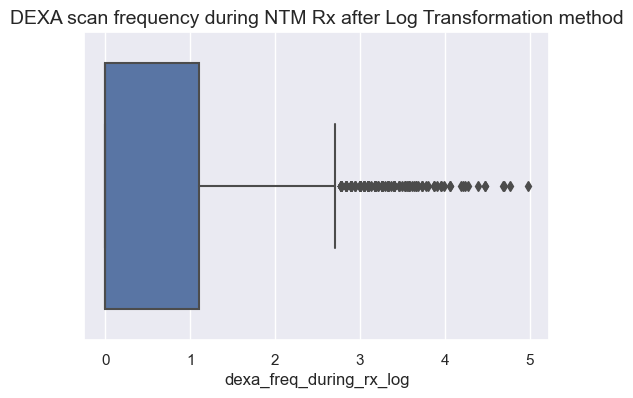

In [17]:
sns.set(rc = {'figure.figsize':(6,4)})
ax = sns.boxplot(x='dexa_freq_during_rx_log', 
                 data=drug_df)
ax.set_title('DEXA scan frequency during NTM Rx after Log Transformation method', 
             fontsize=14)

Text(0.5, 1.0, 'Histogram of Log Transformation of DEXA frequency during NTM Rx feature')

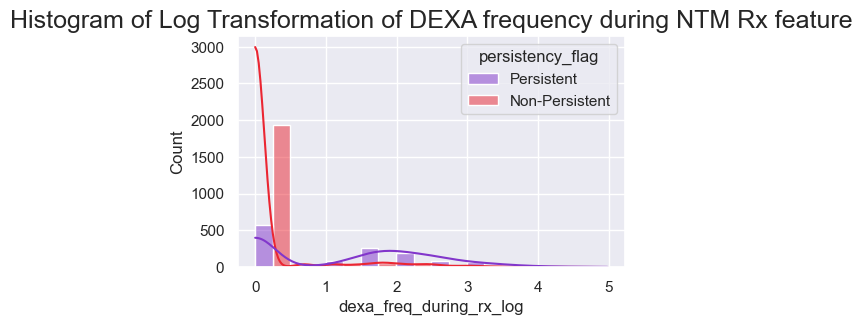

In [20]:
sns.set(rc = {'figure.figsize':(5, 3)})
ax = sns.histplot(x='dexa_freq_during_rx_log', 
                  hue='persistency_flag',
                  stat='count',
                  data=drug_df,
                  palette=col_pal,
                  multiple='dodge', 
                  bins=10,
                  kde=True)
#ax.set_xlim(0, 40)
#ax.set_ylim(0, 750)
ax.set_title('Histogram of Log Transformation of DEXA frequency during NTM Rx feature', 
             fontsize=18)

**Log Transformation** method has changed the values but hasn't reduced the skewness in *dexa_freq_during_rx* column and the outliers content as compared to the **Winsorization** method is more in the data. Hence, we prefer **Winsorization** over this method.

>- ***Winsorization*** on outliers detected via **Z-Score** 

In [40]:
out_cap = drug_df['dexa_freq_during_rx'].quantile(0.95)

drug_df['dexa_freq_during_rx_zscr'] = drug_df['dexa_freq_during_rx']
drug_df['dexa_freq_during_rx_zscr'][outliers] = out_cap

Text(0.5, 1.0, 'DEXA scan frequency during NTM Rx after Winsorization via Z-Score method')

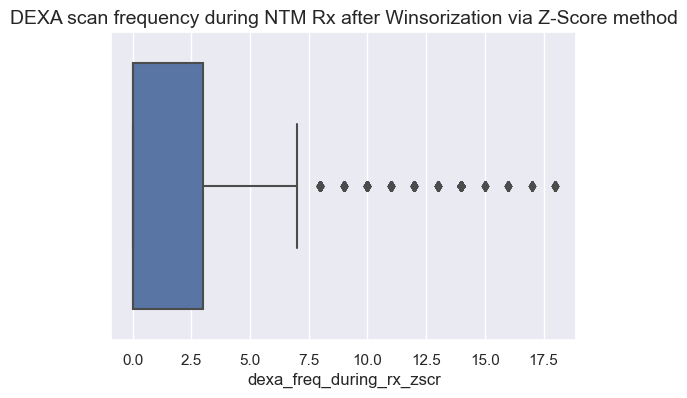

In [41]:
sns.set(rc = {'figure.figsize':(6,4)})
ax = sns.boxplot(x='dexa_freq_during_rx_zscr', 
                 data=drug_df)
ax.set_title('DEXA scan frequency during NTM Rx after Winsorization via Z-Score method', 
             fontsize=14)

We can see that after replacing outliers(detected via Z-Score method with a threshold of 1.96) with the $95^{th}$ percentile of *dexa_freq_during_rx*, the skewness still exists in the data.

Detecting outliers using IQR proves to be the best method as compared to Z-score and treating them vai **Winsorization** method reduces the skewness in the data.

### Multiple Risk Factors Count 

- *Outliers Identification*

>- ***Boxplot visualization***

Text(0.5, 1.0, 'Multiple Risk factors count during NTM Rx')

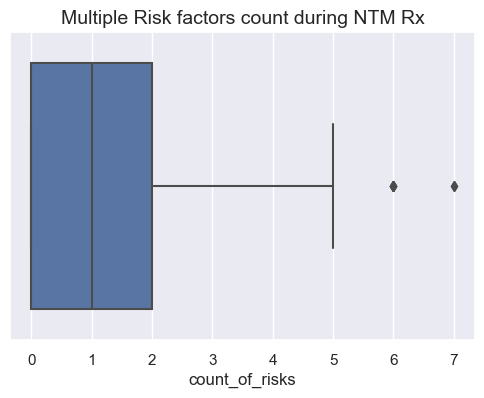

In [42]:
sns.set(rc = {'figure.figsize':(6,4)})
ax = sns.boxplot(x='count_of_risks', 
                 data=drug_df)
ax.set_title('Multiple Risk factors count during NTM Rx', 
             fontsize=14)

Text(0.5, 1.0, 'Multiple Risk factors count during NTM Rx by Persistency')

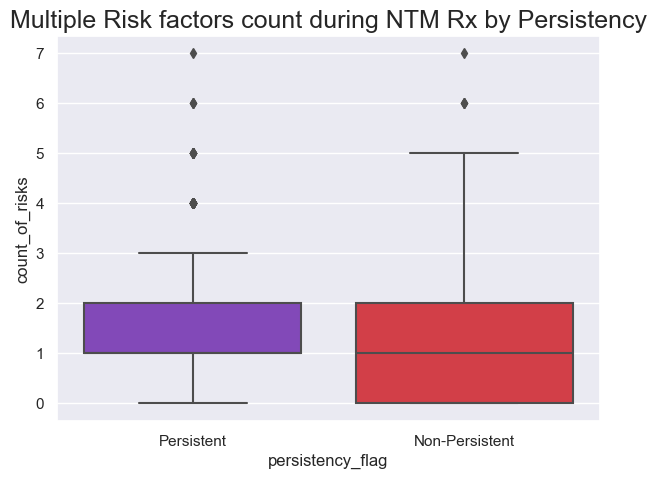

In [44]:
sns.set(rc = {'figure.figsize':(7,5)})
ax = sns.boxplot(y='count_of_risks', 
                 x='persistency_flag',
                 data=drug_df,
                 palette=col_pal)
ax.set_title('Multiple Risk factors count during NTM Rx by Persistency', 
             fontsize=18)

>- ***Histogram visualization***

Text(0.5, 1.0, 'Histogram for Multiple Risk factors during NTM Rx')

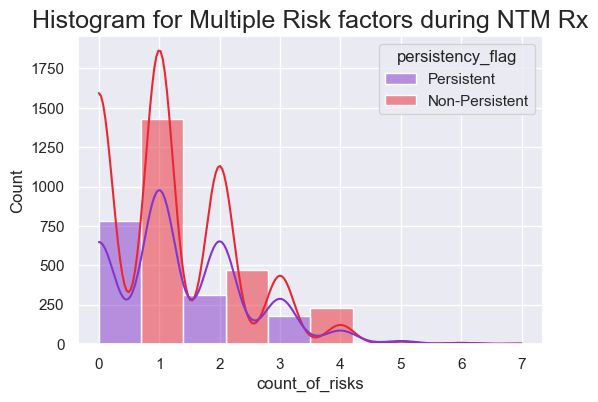

In [53]:
sns.set(rc = {'figure.figsize':(6, 4)})
ax = sns.histplot(x='count_of_risks', 
                  hue='persistency_flag',
                  stat='count',
                  data=drug_df,
                  palette=col_pal,
                  bins=5,
                  multiple='dodge',
                  kde=True)
ax.set_title('Histogram for Multiple Risk factors during NTM Rx', 
             fontsize=18)

In [46]:
drug_df['count_of_risks'].value_counts()

count_of_risks
1    1242
0     970
2     781
3     317
4      91
5      15
6       6
7       2
Name: count, dtype: int64

In [57]:
drug_df.groupby('persistency_flag')['count_of_risks'].describe()

,count,mean,std,min,25%,50%,75%,max
persistency_flag,,,,,,,,
Non-Persistent,2135.0,1.169555,1.068555,0.0,0.0,1.0,2.0,7.0
Persistent,1289.0,1.355314,1.128150,0.0,1.0,1.0,2.0,7.0


- *Handling outliers*

As the *count_of_risks* feature contains 7 different categories and the column describes the no. of risk factors associated with each patient during NTM Rx, the best way to handle the outliers in this section is to reduce the categorisation from 7 to 4 such as 0, 1, 2, and >3.

In [58]:
drug_df['count_of_risks_upd'] = drug_df['count_of_risks']
drug_df.loc[(drug_df['count_of_risks_upd'] >= 3), 'count_of_risks_upd'] = 3

In [59]:
drug_df['count_of_risks_upd'].value_counts()

count_of_risks_upd
1    1242
0     970
2     781
3     431
Name: count, dtype: int64

In [ ]:
sns.set(rc = {'figure.figsize':(7,5)})
ax = sns.boxplot(y='count_of_risks', 
                 x='persistency_flag',
                 data=drug_df,
                 palette=col_pal)
ax.set_title('Multiple Risk factors count during NTM Rx by Persistency', 
             fontsize=18)